# Eksperyment

In [72]:
# Importowanie bibliotek
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.model_selection as skm
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_openml
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# Dla łatwiejszej modyfikacji parametrów
RANDOM_STATE = 16
N_JOBS = -1
CV_SPLITS = 5
SCORING = 'roc_auc'
N_ITER = 100
TEST_SIZE = 0.3
DATASET_IDS = [37]
# DATASET_IDS = [37, 1464, 1063, 1480, 50, 29, 23381, 6332, 40994, 1510, 15, 1494, 1068, 1462, 1049, 1050, 1067, 1487, 1485, 3] 
# 37 - diabetes, 1464 - blood-transfusion-service-center, 1063 - kc2, 1480 - ilpd, 50 - tic-tac-toe
# 29 - credit-approval, 23381 - dresses-sales, 6332 - cylinder-bands, 40994 - climate-model-simulation-crashes, 1510 - wdbc
# 15 - breast-w, 1494 - qsar-biodeg, 1068 - pc1, 1462 - banknote-authentication, 1049 - pc4
# 1050 - pc3, 1067 - kc1, 1487 - ozone-level-8hr, 1485 - madelon,  3 - kr-vs-kp

#### Kroswalidacja

In [56]:
kfold = skm.KFold(CV_SPLITS, random_state = RANDOM_STATE, shuffle=True)

### Surrogate models, acquisition functions

In [57]:
SURROGATE_MODELS = ['GP', 'RF', 'ET']  # Gaussian Process, Random Forest, Extra Trees
ACQUISITION_FUNCTIONS = ['LCB', 'EI', 'PI']  # Lower Confidence Bound, Expected Improvement, Probability of Improvement

# Wszystkie kombinacje
SURROGATE_ACQ = []
for surrogate in SURROGATE_MODELS:
    for acq in ACQUISITION_FUNCTIONS:
        SURROGATE_ACQ.append({
            'name': f'{surrogate}_{acq}',
            'base_estimator': surrogate,
            'acq_func': acq
        })

Modele i hiperparametry

In [58]:
MODELS = {
    'XGBoost': {
        'estimator': XGBClassifier(
            random_state=RANDOM_STATE,
            enable_categorical=False,
            eval_metric='logloss'
        ),
        'params': {
            'bayes': {
                'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'model__max_depth': Integer(3, 9),
                'model__n_estimators': Integer(50, 300),
                'model__subsample': Real(0.6, 1.0),
                'model__reg_lambda': Real(0, 10)
            },
            'random': {
                'model__learning_rate': np.logspace(-2, -0.1, 100),
                'model__max_depth': np.arange(3, 11),
                'model__n_estimators': np.arange(50, 201),
                'model__subsample': np.linspace(0.6, 1.0, 10),
                'model__reg_lambda': np.linspace(0, 10, 10)
            },
            'grid': {
                'model__learning_rate': [0.01, 0.1, 0.2],
                'model__max_depth': [3, 6, 9],
                'model__n_estimators': [100, 200],
                'model__subsample': [0.6, 0.8, 1.0],
                'model__reg_lambda': [0, 5, 10]
            }
        }
    },
    
    'LightGBM': {
        'estimator': LGBMClassifier(
            random_state=RANDOM_STATE,
            force_col_wise=True,
            min_gain_to_split=0.01
        ),
        'params': {
            'bayes': {
                'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'model__num_leaves': Integer(31, 100), 
                'model__n_estimators': Integer(50, 300),
                'model__subsample': Real(0.6, 1.0),
                'model__reg_lambda': Real(0, 10)
            },
            'random': {
                'model__learning_rate': np.logspace(-2, -0.1, 100),
                'model__num_leaves': np.arange(31, 101),
                'model__n_estimators': np.arange(50, 301),
                'model__subsample': np.linspace(0.6, 1.0, 10),
                'model__reg_lambda': np.linspace(0, 10, 10)
            },
            'grid': {
                'model__learning_rate': [0.01, 0.1, 0.3],
                'model__num_leaves': [31, 50, 100],
                'model__n_estimators': [100, 200, 300],
                'model__subsample': [0.6, 0.8, 1.0],
                'model__reg_lambda': [0, 5, 10]
            }
        }
    },
    
    'Random Forest': {
        'estimator': RandomForestClassifier(
            random_state=RANDOM_STATE,
            bootstrap=True
        ),
        'params': {
            'bayes': {
                'model__n_estimators': Integer(50, 300),
                'model__max_depth': Integer(3, 20),
                'model__min_samples_split': Integer(2, 20),
                'model__min_samples_leaf': Integer(1, 20)
            },
            'random': {
                'model__n_estimators': np.arange(50, 301),
                'model__max_depth': np.arange(3, 21),
                'model__min_samples_split': np.arange(2, 21),
                'model__min_samples_leaf': np.arange(1, 21)
            },
            'grid': {
                'model__n_estimators': [100, 200, 300],
                'model__max_depth': [3, 6, 9, None],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            }
        }
    }
}

In [59]:
all_params_set = {
    param_name 
    for model_config in MODELS.values() 
    for method in ['bayes', 'random', 'grid'] 
    for param_name in model_config.get('params', {}).get(method, {})
}

CV_RESULTS_COLUMNS = [
    'mean_test_score', 'std_test_score', 
    'mean_train_score', 'std_train_score',
    'rank_test_score', 'mean_fit_time', 'std_fit_time'
]

META_COLUMNS = ['dataset_id', 'model_name', 'searcher_name', 'n_iter']

ALL_COLUMNS = META_COLUMNS + CV_RESULTS_COLUMNS + sorted(all_params_set)

In [60]:
all_iterations_data = []

In [61]:
results = []

In [62]:
for dataset_id in DATASET_IDS:
    ######################## Dane ########################
    df = fetch_openml(data_id=dataset_id)
    y = df.target
    X = df.data

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    numerical_features = list(X_train.dtypes[(X_train.dtypes != 'object') & (X_train.dtypes != 'category')].index)
    categorical_features = list(X_train.dtypes[(X_train.dtypes == 'object') | (X_train.dtypes == 'category')].index)

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

    ######################## Modele ########################
    for model_name, model_config in MODELS.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_config['estimator'])
        ])
        
        searchers = []
        
        for sur_acq in SURROGATE_ACQ:
            searchers.append((
                f"Bayes_{sur_acq['name']}", 
                BayesSearchCV(
                    estimator=pipeline,
                    search_spaces=model_config['params']['bayes'],
                    n_iter=N_ITER,
                    cv=kfold,
                    scoring=SCORING,
                    n_jobs=N_JOBS,
                    random_state=RANDOM_STATE,
                    optimizer_kwargs={
                        'base_estimator': sur_acq['base_estimator'],
                        'acq_func': sur_acq['acq_func']
                    },
                    return_train_score=True
                )
            ))
        
        searchers.append((
            'RandomSearch',
            RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=model_config['params']['random'],
                n_iter=N_ITER,
                cv=kfold,
                scoring=SCORING,
                n_jobs=N_JOBS,
                random_state=RANDOM_STATE,
                return_train_score=True
            )
        ))
        
        searchers.append((
            'GridSearch',
            GridSearchCV(
                estimator=pipeline,
                param_grid=model_config['params']['grid'],
                cv=kfold,
                scoring=SCORING,
                n_jobs=N_JOBS,
                return_train_score=True
            )
        ))

        ######################## Zapisywanie wyników ########################
        for searcher_name, searcher in searchers:
            start_time = time()
            searcher.fit(X_train, y_train)
            elapsed_time = time() - start_time

            df_iterations = pd.DataFrame(searcher.cv_results_)
            
            df_iterations['n_iter'] = np.arange(1, len(df_iterations) + 1)
            

            params_df = pd.json_normalize(df_iterations['params'])
            params_df = params_df.reindex(columns=sorted(all_params_set), fill_value=np.nan)
            
            df_iterations = pd.concat([
                df_iterations[CV_RESULTS_COLUMNS + ['n_iter']],
                params_df
            ], axis=1)
            
            df_iterations['dataset_id'] = dataset_id
            df_iterations['model_name'] = model_name
            df_iterations['searcher_name'] = searcher_name
            df_iterations['time'] = elapsed_time
            
            df_iterations = df_iterations.reindex(columns=ALL_COLUMNS, fill_value=np.nan)

            all_iterations_data.append(df_iterations)

            # Zapis wyników dla najlepszej iteracji
            best_searcher = searcher.best_estimator_
            auc_test = roc_auc_score(y_test, best_searcher.predict_proba(X_test)[:, 1])
            
            results.append({
                'dataset': dataset_id,
                'model': model_name,
                'method': searcher_name,
                'best_score': round(searcher.best_score_, 4),
                'score_test': round(auc_test, 4),
                'time': round(elapsed_time, 4),
                'best_params': str(searcher.best_params_)
            })

[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Number of positive: 184, number of negative: 353
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,342644 -> initscore=-0,651532
[LightGBM] [Info] Start training from score -0,651532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

c:\Users\zebia\anaconda3\envs\myenv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 19, 17, 86] before, using random point [13, 18, 2, 124]
  warnings.warn(


In [63]:
results_df = pd.DataFrame(results)
results_df

,dataset,model,method,best_score,score_test,time,best_params
0,37,XGBoost,Bayes_GP_LCB,0.8016,0.8639,93.8644,"OrderedDict([('model__learning_rate', 0.012879..."
1,37,XGBoost,Bayes_GP_EI,0.8026,0.8633,92.6035,"OrderedDict([('model__learning_rate', 0.092919..."
2,37,XGBoost,Bayes_GP_PI,0.8008,0.8631,102.0746,"OrderedDict([('model__learning_rate', 0.021094..."
3,37,XGBoost,Bayes_RF_LCB,0.8016,0.8681,48.4848,"OrderedDict([('model__learning_rate', 0.049005..."
4,37,XGBoost,Bayes_RF_EI,0.8011,0.8630,47.9018,"OrderedDict([('model__learning_rate', 0.017090..."
5,37,XGBoost,Bayes_RF_PI,0.8033,0.8657,46.3589,"OrderedDict([('model__learning_rate', 0.041188..."
6,37,XGBoost,Bayes_ET_LCB,0.8016,0.8649,44.9135,"OrderedDict([('model__learning_rate', 0.013649..."
7,37,XGBoost,Bayes_ET_EI,0.8005,0.8696,45.9155,"OrderedDict([('model__learning_rate', 0.103952..."
8,37,XGBoost,Bayes_ET_PI,0.8018,0.8684,43.3935,"OrderedDict([('model__learning_rate', 0.024522..."
9,37,XGBoost,RandomSearch,0.7969,0.8595,4.0553,"{'model__subsample': 0.6444444444444444, 'mode..."


In [67]:
if all_iterations_data:
    all_iterations_df = pd.concat(all_iterations_data, ignore_index=True)
    all_iterations_df.to_csv('all_iterations_results.csv', index=False)

In [68]:
all_iterations_df

,dataset_id,model_name,searcher_name,n_iter,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score,mean_fit_time,std_fit_time,model__learning_rate,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__num_leaves,model__reg_lambda,model__subsample
0,37,XGBoost,Bayes_GP_LCB,1,0.781719,0.025748,0.999246,0.000487,92,0.362613,0.013324,0.078482,9.0,NaN,NaN,182,NaN,4.205855,0.643048
1,37,XGBoost,Bayes_GP_LCB,2,0.783689,0.032486,0.970299,0.005202,90,0.263387,0.009824,0.023923,5.0,NaN,NaN,252,NaN,7.642221,0.988282
2,37,XGBoost,Bayes_GP_LCB,3,0.781673,0.029813,0.953019,0.005421,93,0.122830,0.022311,0.010027,8.0,NaN,NaN,139,NaN,3.552819,0.823041
3,37,XGBoost,Bayes_GP_LCB,4,0.753240,0.032577,1.000000,0.000000,100,0.077253,0.009361,0.210934,6.0,NaN,NaN,225,NaN,2.489506,0.845896
4,37,XGBoost,Bayes_GP_LCB,5,0.781085,0.037863,0.990299,0.001723,94,0.131101,0.010433,0.016566,8.0,NaN,NaN,232,NaN,4.011076,0.966098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,37,Random Forest,GridSearch,104,0.797518,0.027844,0.976507,0.004059,52,0.364746,0.003032,NaN,NaN,4.0,5.0,200,NaN,NaN,NaN
3509,37,Random Forest,GridSearch,105,0.799879,0.027940,0.976738,0.003648,22,0.538160,0.007071,NaN,NaN,4.0,5.0,300,NaN,NaN,NaN
3510,37,Random Forest,GridSearch,106,0.795805,0.027771,0.969055,0.004394,67,0.182989,0.002809,NaN,NaN,4.0,10.0,100,NaN,NaN,NaN
3511,37,Random Forest,GridSearch,107,0.796301,0.024659,0.970856,0.004275,62,0.357158,0.003188,NaN,NaN,4.0,10.0,200,NaN,NaN,NaN


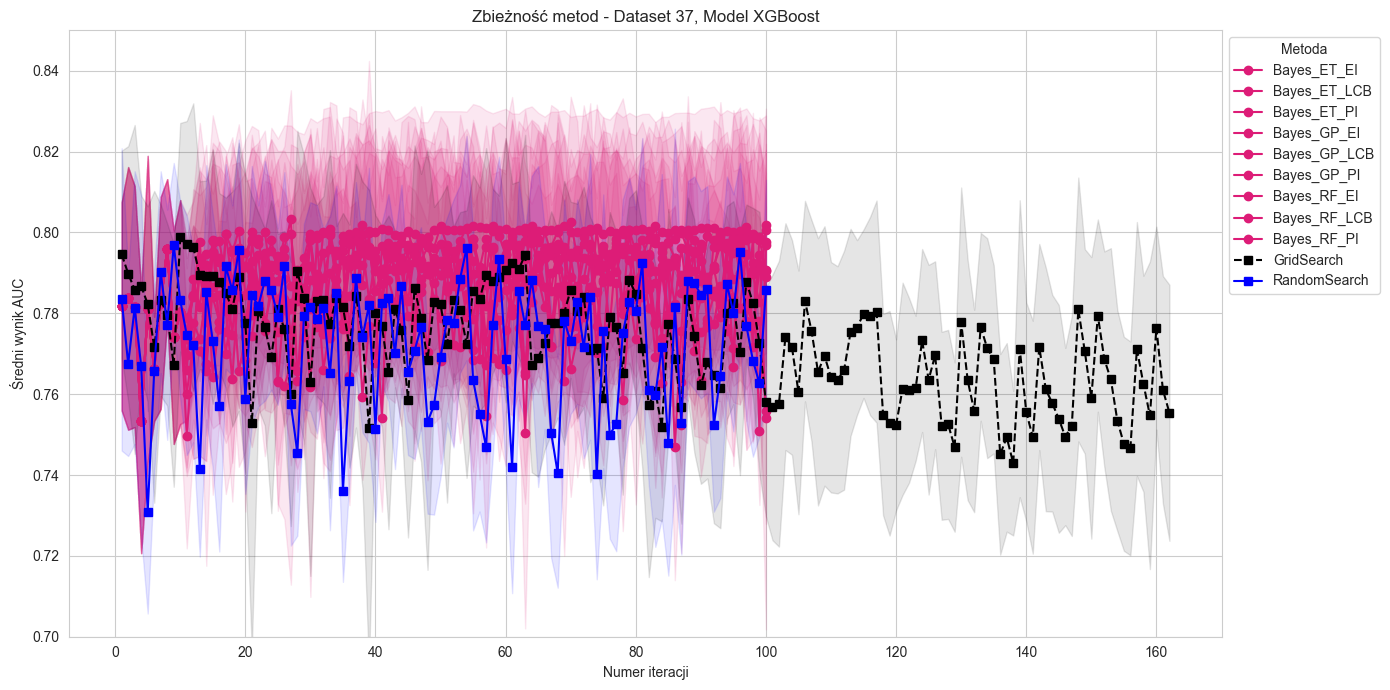

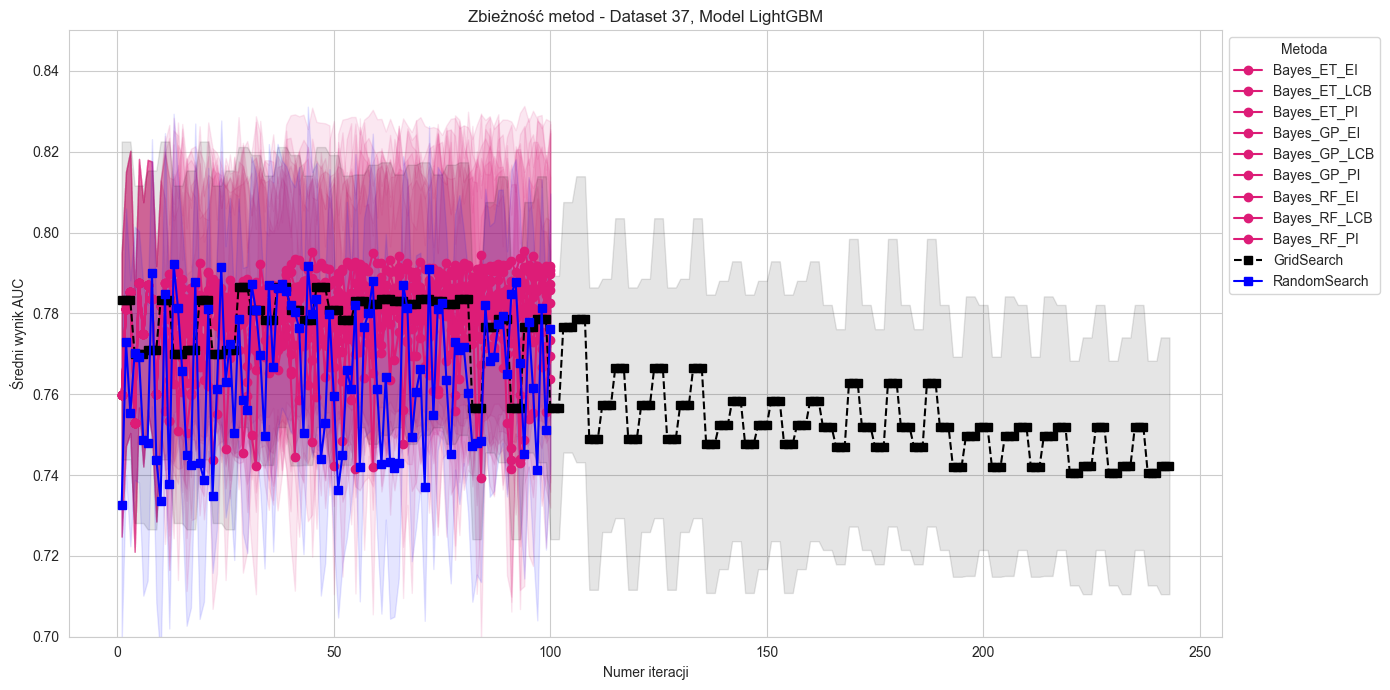

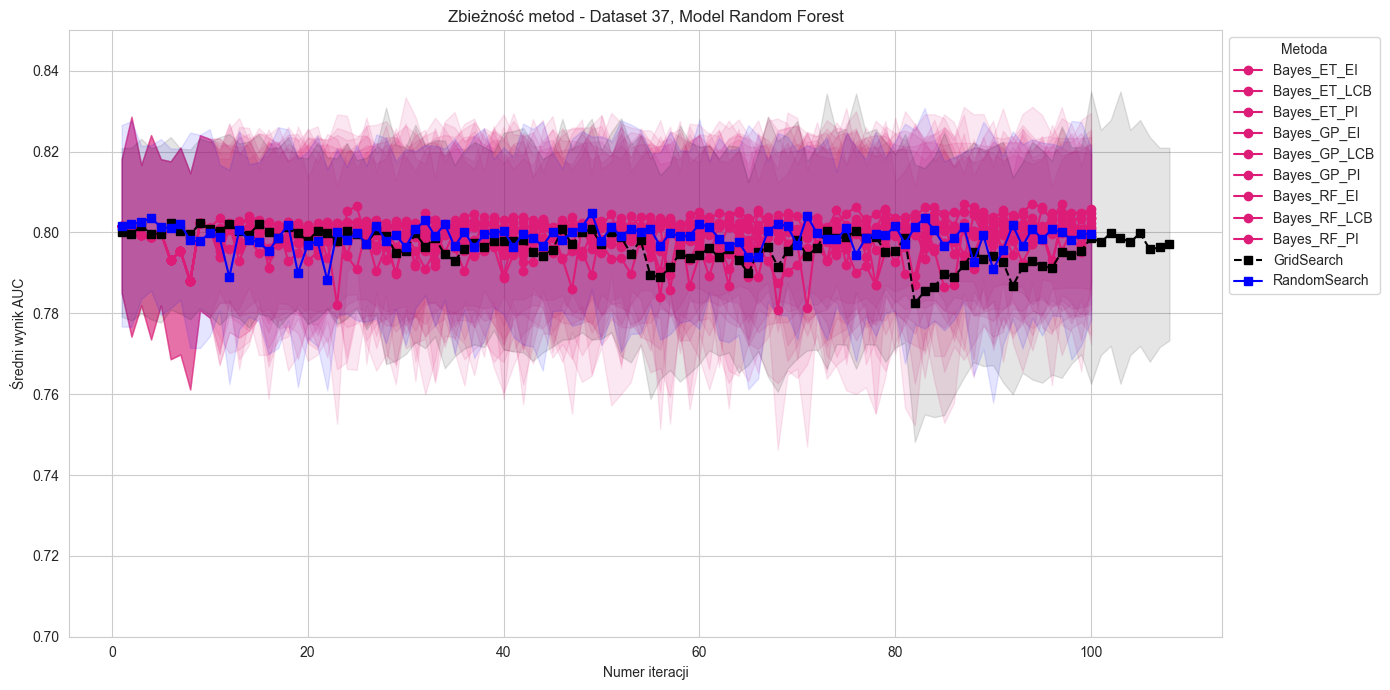

In [107]:
for dataset_id in all_iterations_df['dataset_id'].unique():
    dataset_data = all_iterations_df[all_iterations_df['dataset_id'] == dataset_id]
    
    for model_name in dataset_data['model_name'].unique():
        model_data = dataset_data[dataset_data['model_name'] == model_name]
        
        plt.figure(figsize=(14, 7))
        sns.set_style("whitegrid")
        palette = {'Bayes': '#dd1c77', 'Random': 'blue', 'Grid': 'black'}
        
        plot_data = model_data.groupby(['searcher_name', 'n_iter']).agg(
                    mean=('mean_test_score', 'mean'),
                    std=('std_test_score', 'mean')
                ).reset_index()
        
        for searcher in plot_data['searcher_name'].unique():
            subset = plot_data[plot_data['searcher_name'] == searcher]
            method_type = 'Bayes' if 'Bayes' in searcher else 'Random' if 'Random' in searcher else 'Grid'

            plt.fill_between(subset['n_iter'],
                            subset['mean'] - subset['std'],
                            subset['mean'] + subset['std'],
                            color=palette[method_type],
                            alpha=0.1)
            
            plt.plot(subset['n_iter'], subset['mean'], 
                     color=palette[method_type],
                     label=searcher,
                     marker='o' if method_type == 'Bayes' else 's',
                     linestyle='--' if method_type == 'Grid' else '-')

        plt.title(f'Zbieżność metod - Dataset {dataset_id}, Model {model_name}')
        plt.xlabel('Numer iteracji')
        plt.ylabel('Średni wynik AUC')
        plt.legend(title='Metoda', bbox_to_anchor=(1, 1), loc='upper left')
        plt.ylim(0.7, 0.85)
        plt.tight_layout()
        
        plt.savefig(f'convergence_dataset_{dataset_id}_model_{model_name}.png', dpi=300, bbox_inches='tight')
        
        plt.show()
        
        plt.close()